# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [67]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from bs4 import BeautifulSoup
from prettytable import PrettyTable

### # Here we are taking 30000 data points to implement brute force and 20000 data points for Kd-tree 

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con)

# for knn assignment we are taking 30000 data points for Brute Force and 20000 data points for kd-tree

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 30000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (30000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(28072, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

93.57333333333332

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(28072, 10)


1    23606
0     4466
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
When I ordered these, I thought they were a bit pricey, but I decided to give them a try anyway.  I'm glad I did!  My dogs absolutely love these dried liver treats.  And, since my dogs are all small, I can cut the treats in half and still have large enough pieces to satisfy them. They're great for training; I'll definitely order them again, and would recommend them to anyone.
This was my favorite stevia product and I had it on subscribe and save until I queried customer service about NuNaturals GMO use.  Yes, NuNaturals uses GMO products.  SO, I've canceled my subscribe and save order and am now using <a href="http://www.amazon.com/gp/product/B001ELL3U0">Stevita Stevia Clear Liquid Extract, 3.3-Ounce Container (Pack of 3)</a>.
TOTALLY ORGASMIC.  these chips are the best spicy chip i have ever tasted.  signed up for the subscribe and save

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element


soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
When I ordered these, I thought they were a bit pricey, but I decided to give them a try anyway.  I'm glad I did!  My dogs absolutely love these dried liver treats.  And, since my dogs are all small, I can cut the treats in half and still have large enough pieces to satisfy them. They're great for training; I'll definitely order them again, and would recommend them to anyone.
This was my favorite stevia product and I had it on subscribe and save until I queried customer service about NuNaturals GMO use.  Yes, NuNaturals uses GMO products.  SO, I've canceled my subscribe and save order and am now using Stevita Stevia Clear Liquid Extract, 3.3-Ounce Container (Pack of 3).
TOTALLY ORGASMIC.  these chips are the best spicy chip i have ever tasted.  signed up for the subscribe and save option.  the case contained 15(FIFTEEN, FULL SIZED BAGS) 

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This was my favorite stevia product and I had it on subscribe and save until I queried customer service about NuNaturals GMO use.  Yes, NuNaturals uses GMO products.  SO, I have canceled my subscribe and save order and am now using <a href="http://www.amazon.com/gp/product/B001ELL3U0">Stevita Stevia Clear Liquid Extract, 3.3-Ounce Container (Pack of 3)</a>.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This was my favorite stevia product and I had it on subscribe and save until I queried customer service about NuNaturals GMO use Yes NuNaturals uses GMO products SO I have canceled my subscribe and save order and am now using a href http www amazon com gp product B001ELL3U0 Stevita Stevia Clear Liquid Extract 3 3 Ounce Container Pack of 3 a 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents for brute force and for kd-tree 
from tqdm import tqdm
preprocessed_reviews_brute = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_brute.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 28072/28072 [00:19<00:00, 1428.30it/s]


In [23]:
preprocessed_reviews_brute[1500]

'favorite stevia product subscribe save queried customer service nunaturals gmo use yes nunaturals uses gmo products canceled subscribe save order using'

# [4] Splitting the data

In [24]:
X = preprocessed_reviews_brute
Y = final['Score'].values

In [25]:
#from sklearn.model_selection import train_test_split

# Here we are splitting the data(X ,Y) into train, cross-validation and test data
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30) # this is random splitting
X_train, X_cv, Y_train, Y_cv     = train_test_split(X_train, Y_train, test_size=0.30) # this is random splitting


# [5] Featurization

## [5.1] BAG OF WORDS

In [26]:
#BoW
vectorizer = CountVectorizer(min_df = 10)
vectorizer.fit(X_train) # fit has to happen only on train data
print(vectorizer.get_feature_names()[:20])# printing some feature names
print("="*50)

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

# Converting sparse matrices to dense matrices using todense()
#X_train_bow_dense = X_train_bow.todense()
#X_cv_bow_dense = X_cv_bow.todense()
#X_test_bow_dense = X_test_bow.todense()

print("After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_cv_bow.shape, Y_cv.shape)
print(X_test_bow.shape, Y_test.shape)
print("="*100)

print("the type of count vectorizer ")
print(type(X_train_bow))
print(type(X_cv_bow))
print(type(X_test_bow))
#print(type(X_train_bow_dense))
#print(type(X_cv_bow_dense))
#print(type(X_test_bow_dense))

['ability', 'able', 'absolute', 'absolutely', 'absorbed', 'accept', 'acceptable', 'accepted', 'access', 'accident', 'accidentally', 'according', 'account', 'accurate', 'accustomed', 'acerola', 'ache', 'acid', 'acidic', 'acidity']
After vectorizations
(13755, 4272) (13755,)
(5895, 4272) (5895,)
(8422, 4272) (8422,)
the type of count vectorizer 
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


## [5.2] TF-IDF

In [32]:
tfidf_vect = TfidfVectorizer(min_df=10)
tfidf_vect.fit(X_train)
print("some sample features ",tfidf_vect.get_feature_names()[0:10])
print('='*50)

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tfidf_vect.transform(X_train)
X_cv_tfidf = tfidf_vect.transform(X_cv)
X_test_tfidf = tfidf_vect.transform(X_test)

# Converting sparse matrices to dense matrices using todense()
#X_train_tfidf_dense = X_train_tfidf.todense()
#X_cv_tfidf_dense = X_cv_tfidf.todense()
#X_test_tfidf_dense = X_test_tfidf.todense()


print("After vectorizations")
print(X_train_tfidf.shape, Y_train.shape)
print(X_cv_tfidf.shape, Y_cv.shape)
print(X_test_tfidf.shape, Y_test.shape)
print("="*100)

print("the type of count vectorizer ")
print(type(X_train_tfidf))
print(type(X_cv_tfidf))
print(type(X_test_tfidf))
#print(type(X_train_tfidf_dense))
#print(type(X_cv_tfidf_dense))
#print(type(X_test_tfidf_dense))

some sample features  ['ability', 'able', 'absolute', 'absolutely', 'absorbed', 'accept', 'acceptable', 'accepted', 'access', 'accident']
After vectorizations
(13755, 4272) (13755,)
(5895, 4272) (5895,)
(8422, 4272) (8422,)
the type of count vectorizer 
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


## [5.3] Word2Vec

In [37]:
# Train your own Word2Vec model using your own text corpus
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [38]:
# this line of code trains your w2v model on the give list of sentances, fitting the data
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=-1)

In [39]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  6960
sample words  ['recently', 'decided', 'switch', 'eating', 'whole', 'grains', 'picked', 'box', 'health', 'food', 'store', 'alternative', 'kraft', 'mac', 'cheese', 'son', 'likes', 'prepared', 'per', 'instructions', 'sauce', 'runny', 'quite', 'flavorless', 'one', 'bite', 'would', 'not', 'eat', 'could', 'blame', 'nasty', 'problems', 'wheat', 'pasta', 'neither', 'firm', 'believer', 'healthy', 'delicious', 'time', 'may', 'tasty', 'means', 'worth', 'try', 'hodgson', 'mills', 'macaroni', 'instead']


## [5.4] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [5.4.1] Avg W2v

### Converting Train data text

In [40]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 13755/13755 [00:28<00:00, 471.78it/s]


(13755, 50)
[-7.28030237e-04 -5.56205799e-04  6.96708162e-04 -9.94323137e-04
  1.99799579e-03 -3.06090764e-05 -3.37408963e-04  2.41934864e-04
  5.71718468e-04  1.42863169e-04 -5.05510578e-04 -2.24791103e-04
 -2.05272738e-03 -3.73992505e-04  5.34054237e-04  1.57084703e-04
  2.63559204e-03  1.38472998e-04 -9.27505651e-04  5.94437984e-04
  7.86133576e-04 -2.84614852e-04 -1.27405340e-03  4.87125121e-04
  1.07844425e-04 -2.40434794e-03 -2.02740010e-04 -4.51003476e-04
  7.04643876e-04 -5.06852112e-04  3.93447333e-05 -3.81078242e-04
 -2.17552057e-04  1.22980589e-03 -1.04478319e-04 -3.83046809e-05
 -9.63696161e-04  8.02113810e-04  3.95954851e-04 -1.88403652e-04
  8.11452916e-04 -2.74256269e-04  1.15073252e-03 -5.52021421e-05
  1.39579957e-03  3.98695304e-04  1.74060849e-05 -1.10758668e-03
  6.40169860e-04 -1.47516130e-03]


### Converting CV data set

In [41]:
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [42]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|█████████████████████████████████████████████████████████████████████████████| 5895/5895 [00:11<00:00, 497.85it/s]


(5895, 50)
[-3.84999044e-04 -1.62798005e-03  8.35965096e-04  9.28038169e-04
 -3.34341857e-04 -4.31816358e-04 -1.24536021e-03 -3.94480221e-04
 -5.36312796e-04  2.64958829e-04  3.84126660e-04  2.86912669e-04
 -7.80743565e-05  1.80455835e-03  3.67706328e-04 -1.61825398e-03
 -1.95854987e-04 -5.80343698e-04  2.89902666e-04 -7.74124335e-06
  1.02886048e-03  1.69329977e-03  1.83655066e-03 -1.09511408e-05
  1.18520153e-03 -2.29044315e-03 -4.67157203e-04 -2.35021164e-04
 -6.42706934e-04 -1.42672633e-05 -4.82613692e-04 -1.21197277e-03
 -1.73303478e-04  4.55005670e-04  6.06763872e-04  1.16039021e-03
 -1.35595337e-03  9.34729866e-04  1.37707340e-03 -5.81176302e-04
 -1.48547750e-04  2.33136973e-03  2.02083795e-03  2.07473299e-03
  1.19471143e-03  1.29596306e-03  1.44880712e-03  1.28350783e-03
  8.83198263e-04 -8.46908831e-04]


### Converting Test data set

In [43]:
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [44]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|█████████████████████████████████████████████████████████████████████████████| 8422/8422 [00:17<00:00, 468.00it/s]


(8422, 50)
[ 2.28205948e-04  1.28611838e-03 -1.57975576e-03 -9.07208450e-05
  3.99948034e-04  1.83074613e-04  8.91493453e-04 -3.39986238e-05
  9.22569754e-04  1.09021714e-03 -1.27648838e-03 -1.22697022e-03
 -3.83160310e-04 -1.23340859e-04 -6.12549358e-05 -4.24007455e-04
 -5.53132321e-04 -1.12954486e-03 -3.66102192e-04 -2.54979848e-04
 -1.22224372e-04  5.36628339e-04  1.45276486e-03  2.43383675e-04
 -1.00486289e-03 -1.76401583e-04 -5.02699882e-05 -3.00670783e-04
 -4.81985011e-05  1.03228104e-03 -1.12129276e-03  3.70608653e-04
  1.27988268e-03 -1.07616706e-03 -3.53075413e-04  1.84349937e-03
  2.65070756e-05  7.85864667e-04 -3.78744822e-04  1.47771312e-03
 -2.35357242e-03 -2.00831955e-03  2.75192837e-04  2.93991345e-04
  1.30149733e-03  8.12877757e-04  1.03024263e-03  1.39513008e-05
 -1.59260076e-03 -4.37515883e-04]


#### [5.4.2] TFIDF weighted W2v

### Converting train data set 

In [50]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [51]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 13755/13755 [01:35<00:00, 144.27it/s]


### Converting CV data set

In [52]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 5895/5895 [00:39<00:00, 149.33it/s]


### Converting Test data set

In [53]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 8422/8422 [00:59<00:00, 141.58it/s]


# [6] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [7] Applying KNN brute force

### [7.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

## Hyperparameter tuning using GridSearch

Some points to mention before doing Hyperparameter Tuning:

1. We have splitted our data randomly into three parts- TRAIN, CV, TEST
2. To find nearest neighbours we use TRAIN data and to find best K we use CV data.
3. By using K-Fold cross validation technique, we will combine CV and TRAIN data and use it as TRAIN data because if we
   have more TRAIN data our model will work more better on unseen TEST data.

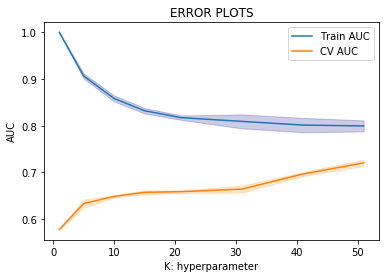

In [27]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

neigh = KNeighborsClassifier(algorithm='brute')
K = [1, 5, 10, 15, 21, 31, 41, 51]
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc', n_jobs=-1)
clf.fit(X_train_bow, Y_train)

train_auc_bow = clf.cv_results_['mean_train_score']
train_auc_std_bow = clf.cv_results_['std_train_score']
cv_auc_bow = clf.cv_results_['mean_test_score'] 
cv_auc_std_bow = clf.cv_results_['std_test_score']

plt.plot(K, train_auc_bow, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc_bow - train_auc_std_bow,train_auc_bow + train_auc_std_bow,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc_bow, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc_bow - cv_auc_std_bow,cv_auc_bow + cv_auc_std_bow,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [28]:
print(clf.best_estimator_)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=51, p=2,
           weights='uniform')


In [58]:
#here we are choosing the best_k based on GridSearchCV results
best_k_bbow = 51

## Testing with Test data

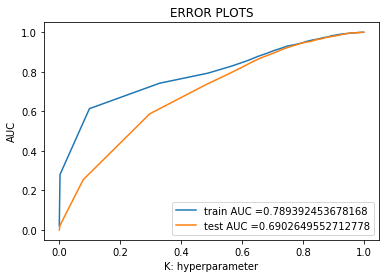

Train confusion matrix
[[   72  2028]
 [   42 11613]]
Test confusion matrix
[[  45 1345]
 [  21 7011]]


In [30]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

neigh = KNeighborsClassifier(n_neighbors=best_k_bbow, algorithm='brute')
neigh.fit(X_train_bow, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr_bow, train_tpr_bow, thresholds_bow = roc_curve(Y_train, neigh.predict_proba(X_train_bow)[:,1])
test_fpr_bow, test_tpr_bow, thresholds_bow = roc_curve(Y_test, neigh.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr_bow, train_tpr_bow, label="train AUC ="+str(auc(train_fpr_bow, train_tpr_bow)))
plt.plot(test_fpr_bow, test_tpr_bow, label="test AUC ="+str(auc(test_fpr_bow, test_tpr_bow)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)


print("Train confusion matrix")
print(confusion_matrix(Y_train, neigh.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, neigh.predict(X_test_bow)))

### How to plot ROC curve using AUC and K hyperparameter: 

1. To plot ROC curve we need to calculate AUC(Area under curve ROC)
2. For each data point we have class labels(y)
3. We have predicted score(ŷ) for each point( More is the score, more chance that point belongs to class 1)
4. Then we set highest value of ŷ as our threshold value(tau) and calculate new predicted class label (ỹ)
5. For each predicted class label(ỹ) we can calculate True positive rate(TPR) and False positive rate(FPR) at different 
   threshold values(1,2,3...n)
6. TPR and FPR values are used to plot ROC curve.

### [7.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

## Hyperparameter tuning using GridSearch

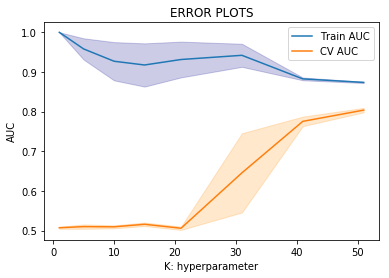

In [33]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
neigh = KNeighborsClassifier(algorithm='brute')
K = [1, 5, 10, 15, 21, 31, 41, 51]
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc', n_jobs=-1)
clf.fit(X_train_tfidf, Y_train)

train_auc_tfidf = clf.cv_results_['mean_train_score']
train_auc_std_tfidf = clf.cv_results_['std_train_score']
cv_auc_tfidf = clf.cv_results_['mean_test_score'] 
cv_auc_std_tfidf = clf.cv_results_['std_test_score']

plt.plot(K, train_auc_tfidf, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc_tfidf - train_auc_std_tfidf,train_auc_tfidf + train_auc_std_tfidf,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc_tfidf, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc_tfidf - cv_auc_std_tfidf,cv_auc_tfidf + cv_auc_std_tfidf,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [34]:
print(clf.best_estimator_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=51, p=2,
           weights='uniform')


In [59]:
#here we are choosing the best_k based on GridSearchCV results
best_k_btfidf = 51

## Testing with test data

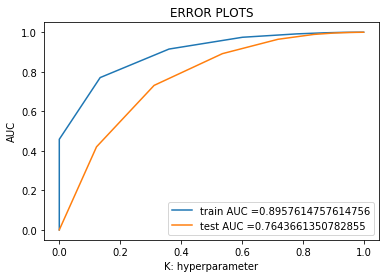

Train confusion matrix
[[    0  2100]
 [    0 11655]]
Test confusion matrix
[[   0 1390]
 [   0 7032]]


In [36]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

neigh = KNeighborsClassifier(n_neighbors=best_k_btfidf, algorithm='brute')
neigh.fit(X_train_tfidf, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr_tfidf, train_tpr_tfidf, thresholds_tfidf = roc_curve(Y_train, neigh.predict_proba(X_train_tfidf)[:,1])
test_fpr_tfidf, test_tpr_tfidf, thresholds_tfidf = roc_curve(Y_test, neigh.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)


print("Train confusion matrix")
print(confusion_matrix(Y_train, neigh.predict(X_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, neigh.predict(X_test_tfidf)))

### [7.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

## Hyperparameter tuning using GridSearch

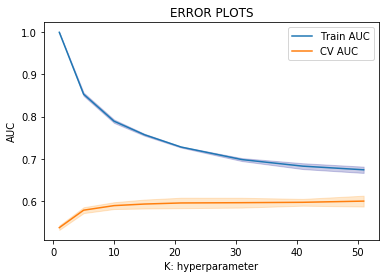

In [45]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
neigh = KNeighborsClassifier(algorithm='brute')
K = [1, 5, 10, 15, 21, 31, 41, 51]
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc', n_jobs=-1)
clf.fit(sent_vectors_train, Y_train)

train_auc_aw2v     = clf.cv_results_['mean_train_score']
train_auc_std_aw2v = clf.cv_results_['std_train_score']
cv_auc_aw2v        = clf.cv_results_['mean_test_score'] 
cv_auc_std_aw2v    = clf.cv_results_['std_test_score']

plt.plot(K, train_auc_aw2v, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc_aw2v - train_auc_std_aw2v,train_auc_aw2v + train_auc_std_aw2v,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc_aw2v, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc_aw2v - cv_auc_std_aw2v,cv_auc_aw2v + cv_auc_std_aw2v,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [46]:
print(clf.best_estimator_)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=51, p=2,
           weights='uniform')


In [61]:
#here we are choosing the best_k based on GridSearchCV results
best_k_baw2v = 51

## Testing with test data 

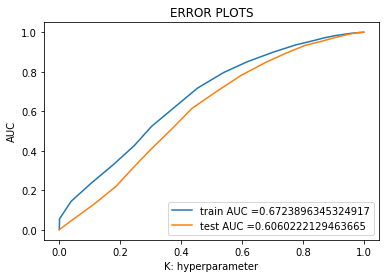

Train confusion matrix
[[    5  2095]
 [    1 11654]]
Test confusion matrix
[[   2 1388]
 [   1 7031]]


In [48]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

neigh = KNeighborsClassifier(n_neighbors=best_k_baw2v, algorithm='brute')
neigh.fit(sent_vectors_train, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr_aw2v, train_tpr_aw2v, thresholds_aw2v = roc_curve(Y_train, neigh.predict_proba(sent_vectors_train)[:,1])
test_fpr_aw2v, test_tpr_aw2v, thresholds_aw2v = roc_curve(Y_test, neigh.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr_aw2v, train_tpr_aw2v, label="train AUC ="+str(auc(train_fpr_aw2v, train_tpr_aw2v)))
plt.plot(test_fpr_aw2v, test_tpr_aw2v, label="test AUC ="+str(auc(test_fpr_aw2v, test_tpr_aw2v)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)


print("Train confusion matrix")
print(confusion_matrix(Y_train, neigh.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, neigh.predict(sent_vectors_test)))

### [7.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

## Hyperparameter tuning using GridSearch

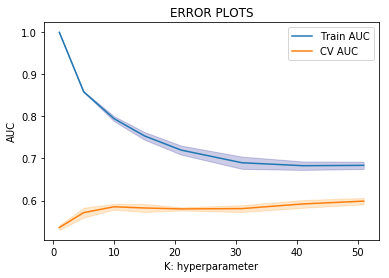

In [54]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
neigh = KNeighborsClassifier(algorithm='brute')
K = [1, 5, 10, 15, 21, 31, 41, 51]
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc', n_jobs=-1)
clf.fit(tfidf_sent_vectors_train, Y_train)

train_auc_tfw2v     = clf.cv_results_['mean_train_score']
train_auc_std_tfw2v = clf.cv_results_['std_train_score']
cv_auc_tfw2v        = clf.cv_results_['mean_test_score'] 
cv_auc_std_tfw2v    = clf.cv_results_['std_test_score']

plt.plot(K, train_auc_tfw2v, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc_tfw2v - train_auc_std_tfw2v,train_auc_tfw2v + train_auc_std_tfw2v,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc_tfw2v, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc_tfw2v - cv_auc_std_tfw2v,cv_auc_tfw2v + cv_auc_std_tfw2v,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [55]:
print(clf.best_estimator_)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=51, p=2,
           weights='uniform')


In [62]:
#here we are choosing the best_k based on GridSearchCV results
best_k_btfw2v = 51

## Testing with test data 

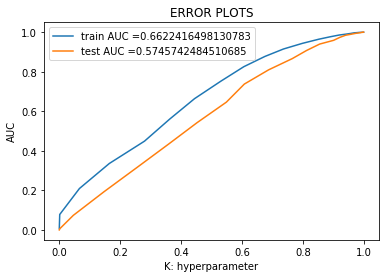

Train confusion matrix
[[    5  2095]
 [    0 11655]]
Test confusion matrix
[[   0 1390]
 [   1 7031]]


In [57]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

neigh = KNeighborsClassifier(n_neighbors=best_k_btfw2v, algorithm='brute')
neigh.fit(tfidf_sent_vectors_train, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr_tfw2v, train_tpr_tfw2v, thresholds_tfw2v = roc_curve(Y_train, neigh.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr_tfw2v, test_tpr_tfw2v, thresholds_tfw2v = roc_curve(Y_test, neigh.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr_tfw2v, train_tpr_tfw2v, label="train AUC ="+str(auc(train_fpr_tfw2v, train_tpr_tfw2v)))
plt.plot(test_fpr_tfw2v, test_tpr_tfw2v, label="test AUC ="+str(auc(test_fpr_tfw2v, test_tpr_tfw2v)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)


print("Train confusion matrix")
print(confusion_matrix(Y_train, neigh.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, neigh.predict(tfidf_sent_vectors_test)))

## [8] Applying KNN kd-tree

### [8.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

## Hyperparameter tuning using GridSearch

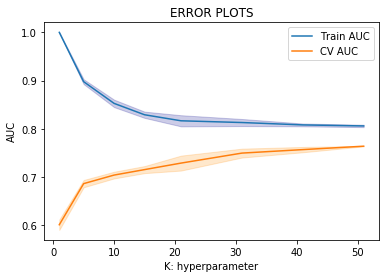

In [41]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

neigh = KNeighborsClassifier(algorithm='kd_tree')
K = [1, 5, 10, 15, 21, 31, 41, 51]
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc', n_jobs=-1)
clf.fit(X_train_bow_dense, Y_train)

train_auc_bow = clf.cv_results_['mean_train_score']
train_auc_std_bow = clf.cv_results_['std_train_score']
cv_auc_bow = clf.cv_results_['mean_test_score'] 
cv_auc_std_bow = clf.cv_results_['std_test_score']

plt.plot(K, train_auc_bow, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc_bow - train_auc_std_bow,train_auc_bow + train_auc_std_bow,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc_bow, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc_bow - cv_auc_std_bow,cv_auc_bow + cv_auc_std_bow,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [42]:
print(clf.best_estimator_)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=51, p=2,
           weights='uniform')


In [63]:
#here we are choosing the best_k based on GridSearchCV results
best_k_kdbow = 51

## Testing with Test Data

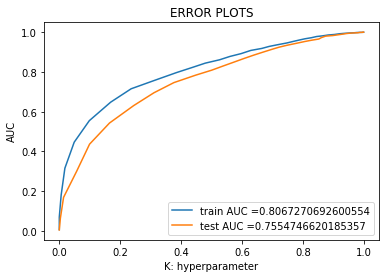

Train confusion matrix
[[ 199 1271]
 [ 146 7866]]
Test confusion matrix
[[  87  768]
 [  83 4869]]


In [48]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

neigh = KNeighborsClassifier(n_neighbors=best_k_kdbow, algorithm='kd_tree')
neigh.fit(X_train_bow_dense, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr_bow, train_tpr_bow, thresholds_bow = roc_curve(Y_train, neigh.predict_proba(X_train_bow_dense)[:,1])
test_fpr_bow, test_tpr_bow, thresholds_bow = roc_curve(Y_test, neigh.predict_proba(X_test_bow_dense)[:,1])

plt.plot(train_fpr_bow, train_tpr_bow, label="train AUC ="+str(auc(train_fpr_bow, train_tpr_bow)))
plt.plot(test_fpr_bow, test_tpr_bow, label="test AUC ="+str(auc(test_fpr_bow, test_tpr_bow)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)


print("Train confusion matrix")
print(confusion_matrix(Y_train, neigh.predict(X_train_bow_dense)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, neigh.predict(X_test_bow_dense)))

### [8.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

## Hyperparameter tuning using GridSearch

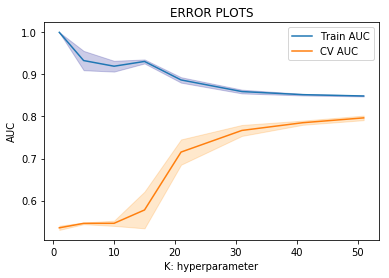

In [49]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

neigh = KNeighborsClassifier(algorithm='kd_tree')
K = [1, 5, 10, 15, 21, 31, 41, 51]
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc', n_jobs=-1)
clf.fit(X_train_tfidf_dense, Y_train)

train_auc_bow = clf.cv_results_['mean_train_score']
train_auc_std_bow = clf.cv_results_['std_train_score']
cv_auc_bow = clf.cv_results_['mean_test_score'] 
cv_auc_std_bow = clf.cv_results_['std_test_score']

plt.plot(K, train_auc_bow, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc_bow - train_auc_std_bow,train_auc_bow + train_auc_std_bow,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc_bow, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc_bow - cv_auc_std_bow,cv_auc_bow + cv_auc_std_bow,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [50]:
print(clf.best_estimator_)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=51, p=2,
           weights='uniform')


In [64]:
#here we are choosing the best_k based on GridSearchCV results
best_k_kdtfidf = 51

## Testing with Test Data

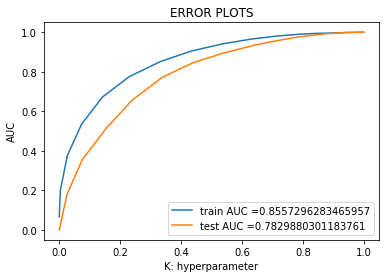

Train confusion matrix
[[   0 1470]
 [   0 8012]]
Test confusion matrix
[[   0  855]
 [   0 4952]]


In [52]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

neigh = KNeighborsClassifier(n_neighbors=best_k_kdtfidf, algorithm='kd_tree')
neigh.fit(X_train_tfidf_dense, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr_bow, train_tpr_bow, thresholds_bow = roc_curve(Y_train, neigh.predict_proba(X_train_tfidf_dense)[:,1])
test_fpr_bow, test_tpr_bow, thresholds_bow = roc_curve(Y_test, neigh.predict_proba(X_test_tfidf_dense)[:,1])

plt.plot(train_fpr_bow, train_tpr_bow, label="train AUC ="+str(auc(train_fpr_bow, train_tpr_bow)))
plt.plot(test_fpr_bow, test_tpr_bow, label="test AUC ="+str(auc(test_fpr_bow, test_tpr_bow)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)


print("Train confusion matrix")
print(confusion_matrix(Y_train, neigh.predict(X_train_tfidf_dense)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, neigh.predict(X_test_tfidf_dense)))

### [8.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

## Hyperparameter tuning using GridSearch

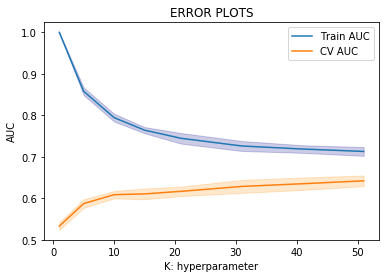

In [53]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
neigh = KNeighborsClassifier(algorithm='kd_tree')
K = [1, 5, 10, 15, 21, 31, 41, 51]
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc', n_jobs=-1)
clf.fit(sent_vectors_train, Y_train)

train_auc_aw2v     = clf.cv_results_['mean_train_score']
train_auc_std_aw2v = clf.cv_results_['std_train_score']
cv_auc_aw2v        = clf.cv_results_['mean_test_score'] 
cv_auc_std_aw2v    = clf.cv_results_['std_test_score']

plt.plot(K, train_auc_aw2v, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc_aw2v - train_auc_std_aw2v,train_auc_aw2v + train_auc_std_aw2v,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc_aw2v, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc_aw2v - cv_auc_std_aw2v,cv_auc_aw2v + cv_auc_std_aw2v,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [54]:
print(clf.best_estimator_)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=51, p=2,
           weights='uniform')


In [65]:
#here we are choosing the best_k based on GridSearchCV results
best_k_kdaw2v = 51

## Testing with test data 

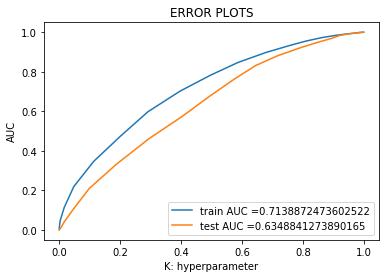

Train confusion matrix
[[   4 1466]
 [   0 8012]]
Test confusion matrix
[[   1  854]
 [   0 4952]]


In [57]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

neigh = KNeighborsClassifier(n_neighbors=best_k_kdaw2v, algorithm='kd_tree')
neigh.fit(sent_vectors_train, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr_aw2v, train_tpr_aw2v, thresholds_aw2v = roc_curve(Y_train, neigh.predict_proba(sent_vectors_train)[:,1])
test_fpr_aw2v, test_tpr_aw2v, thresholds_aw2v = roc_curve(Y_test, neigh.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr_aw2v, train_tpr_aw2v, label="train AUC ="+str(auc(train_fpr_aw2v, train_tpr_aw2v)))
plt.plot(test_fpr_aw2v, test_tpr_aw2v, label="test AUC ="+str(auc(test_fpr_aw2v, test_tpr_aw2v)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)


print("Train confusion matrix")
print(confusion_matrix(Y_train, neigh.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, neigh.predict(sent_vectors_test)))

### [8.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

## Hyperparameter tuning using GridSearch

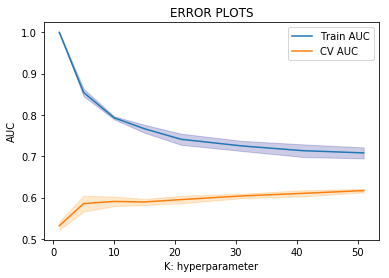

In [58]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
neigh = KNeighborsClassifier(algorithm='kd_tree')
K = [1, 5, 10, 15, 21, 31, 41, 51]
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc', n_jobs=-1)
clf.fit(tfidf_sent_vectors_train, Y_train)

train_auc_tfw2v     = clf.cv_results_['mean_train_score']
train_auc_std_tfw2v = clf.cv_results_['std_train_score']
cv_auc_tfw2v        = clf.cv_results_['mean_test_score'] 
cv_auc_std_tfw2v    = clf.cv_results_['std_test_score']

plt.plot(K, train_auc_tfw2v, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc_tfw2v - train_auc_std_tfw2v,train_auc_tfw2v + train_auc_std_tfw2v,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc_tfw2v, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc_tfw2v - cv_auc_std_tfw2v,cv_auc_tfw2v + cv_auc_std_tfw2v,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [59]:
print(clf.best_estimator_)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=51, p=2,
           weights='uniform')


In [66]:
#here we are choosing the best_k based on GridSearchCV results
best_k_kdtfw2v = 51

## Testing with Test data 

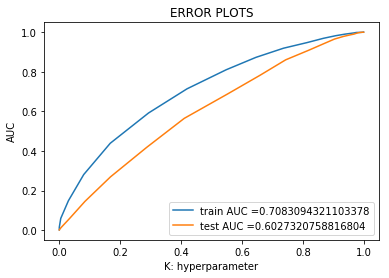

Train confusion matrix
[[   0 1470]
 [   1 8011]]
Test confusion matrix
[[   0  855]
 [   0 4952]]


In [61]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

neigh = KNeighborsClassifier(n_neighbors=best_k_kdtfw2v, algorithm='kd_tree')
neigh.fit(tfidf_sent_vectors_train, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr_tfw2v, train_tpr_tfw2v, thresholds_tfw2v = roc_curve(Y_train, neigh.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr_tfw2v, test_tpr_tfw2v, thresholds_tfw2v = roc_curve(Y_test, neigh.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr_tfw2v, train_tpr_tfw2v, label="train AUC ="+str(auc(train_fpr_tfw2v, train_tpr_tfw2v)))
plt.plot(test_fpr_tfw2v, test_tpr_tfw2v, label="test AUC ="+str(auc(test_fpr_tfw2v, test_tpr_tfw2v)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)


print("Train confusion matrix")
print(confusion_matrix(Y_train, neigh.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, neigh.predict(tfidf_sent_vectors_test)))

# [9] Conclusions

In [72]:
# Please compare all your models using Prettytable library
name= ["Brute Force for BOW", "Brute Force for TFIDF", "Brute Force for Avg W2V", "Brute Force for TFIDF W2V", "Kd-Tree for BOW", "KD-Tree for TFIDF", "KD-Tree for Avg W2V", "KD-Tree for TFIDF W2V"]
best_k = [best_k_bbow, best_k_btfidf, best_k_baw2v, best_k_btfw2v, best_k_kdbow, best_k_kdtfidf, best_k_kdaw2v, best_k_kdtfw2v]
number = [1,2,3,4,5,6,7,8]
#Initializa Prettytable
ptable = PrettyTable()
ptable.add_column("Index", number)
ptable.add_column("Model", name)
ptable.add_column("Value for K", best_k)

print(ptable)


+-------+---------------------------+-------------+
| Index |           Model           | Value for K |
+-------+---------------------------+-------------+
|   1   |    Brute Force for BOW    |      51     |
|   2   |   Brute Force for TFIDF   |      51     |
|   3   |  Brute Force for Avg W2V  |      51     |
|   4   | Brute Force for TFIDF W2V |      51     |
|   5   |      Kd-Tree for BOW      |      51     |
|   6   |     KD-Tree for TFIDF     |      51     |
|   7   |    KD-Tree for Avg W2V    |      51     |
|   8   |   KD-Tree for TFIDF W2V   |      51     |
+-------+---------------------------+-------------+


### Observation

1. After plotting all the values for AUC, we observed that AUC values for BOW and TFIDF vectorizations are better than    
   Avg W2V and TFIDF Weighted W2V 
2. Also TFIDF performs better than BOW because more the value of AUC(0<AUC<1) more better model performs
3. Best Hyperparameter(K) value for all the models is 51
4. If we could have more training data to train our model, our model would work a lot better. So when we split our data
   randomly into three parts(TRAIN, CV, TEST) we use K-Fold cross validation to use CV data also as TRAIN data. 